In [1]:
import os, sys
project_dir = os.path.join(os.getcwd(),'..')
if project_dir not in sys.path:
    sys.path.append(project_dir)

from ADeLEn.model import ADeLEn
from dataset import AnomalyMNIST
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.nn.functional import mse_loss
from torchvision.transforms import Normalize,ToTensor, Compose
from VAE.loss import SGVBL


import torch

This notebook is used to evaluate how affect the use of new anomalies in the proposed ADeLEn method and the supervised DNN. This test has been carried out using the MNIST dataset.

In [2]:
seed = 42
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

# dataset = AnomalyMNIST('data/', download=True, transform=transform, n_known_anomalies=512, pollution=0.25, seed=seed)
dataset = AnomalyMNIST('data/', download=True, transform=transform, n_normal_samples=2000, known_anomalies=0.1, pollution=0.1, seed=seed)
print(dataset)

AnomalyMNIST Dataset (Number of samples: 2400, Number of known anomalies: 200, Number of unknown anomalies: 200)


In [3]:
# TODO: Include the test set configuration in the AnoamlyMNIST class
from torchvision.datasets import MNIST
from torch.utils.data import Subset, DataLoader

test_dataset = MNIST('data/', train = False, download = True, transform=transform)
normal_idx = torch.where((test_dataset.targets == 1))[0]
non_observed_anomaly_idx = torch.where((test_dataset.targets == 9))[0]
test_dataset = Subset(test_dataset, torch.cat([normal_idx, non_observed_anomaly_idx]))

# ADeLEn

In [4]:
def _weights(dataset):
    import numpy as np
    _, y = zip(*dataset)
    y = torch.tensor(y)

    count = torch.bincount(y)
    weights = 1. / np.array(count)
    weights /= weights.sum()

    return weights[y]

def adelen_train(model, dataset, batch_size, n_epochs, lr=1e-3, kl_weight=1, weighted_sampler=False):
    from tqdm import tqdm
    from torch.utils.data import DataLoader
    from torch.optim import Adam
    
    if weighted_sampler:
        sampler = torch.utils.data.WeightedRandomSampler(_weights(dataset), len(dataset), replacement=True)
        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
    else:
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.train()

    epoch_iterator = tqdm(
            range(n_epochs),
            leave=True,
            unit="epoch",
            postfix={"tls": "%.4f" % -1},
        )
    
    opt = Adam(model.parameters(), lr=lr)
    sgvbl = SGVBL(model, len(dataset), mle=mse_loss)

    for _ in epoch_iterator:
        epoch_loss = 0.
        for x, y in train_loader:
            x = x.to(device) 
            opt.zero_grad()
            x_hat = torch.tanh(model(x))
            loss = sgvbl(x, x_hat, y, kl_weight)
            epoch_loss += loss.detach().item()

            loss.backward()
            opt.step()

        epoch_iterator.set_postfix(tls="%.3f" % (epoch_loss/len(train_loader)))

    return model.eval().cpu()

In [6]:
d = 2
adelen_model = ADeLEn((28, 28), [1, 32, 48], [1024, 256, 32], bottleneck=d, skip_connection=False)
model = adelen_train(adelen_model, dataset, 128, 100, 1e-3, 1, weighted_sampler=False)

100%|██████████| 100/100 [00:52<00:00,  1.90epoch/s, tls=472.235]


NameError: name 'x_test' is not defined

In [13]:
x_test, y_test = zip(*test_dataset)
x_test = torch.stack(x_test)
y_test = torch.tensor(y_test).flatten()
y_test = torch.where(y_test == 1, 0, 1)

scores = model.score_samples(x_test)
(scores[y_test == 0], scores[y_test == 1])
fpr, tpr, _ = roc_curve(y_test, scores)
roc_auc = auc(fpr, tpr)

In [15]:
import numpy as np

def adelen_threshold(sigma, d)->float:
        score = d * np.log(sigma)
        gauss = d * np.log(2*torch.pi*torch.e)
        return .5 * (gauss + score)

def testing(test_dataset, model):
    x, y = zip(*test_dataset)
    x = torch.stack(x)
    y = torch.tensor(y)
    y[y == 1] = 0
    y[y == 9] = 1

    model.eval()
    _ = model(x)
    y_score = model.score_samples(x)
    fpr, tpr, _ = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)
    y_pred = np.where(y_score > adelen_threshold(1.2, d), 1, 0)


    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    return (accuracy, precision, recall, f1, roc_auc)    

def scores(test_dataset, model):
    x, y = zip(*test_dataset)
    x = torch.stack(x)
    y = torch.tensor(y)
    y[y == 1] = 0
    y[y == 9] = 1

    model.eval()
    _ = model(x)
    y_score = model.score_samples(x)
    return (y_score[y == 0], y_score[y == 1])

accuracy, precision, recall, f1, roc_auc = testing(test_dataset, model)
normal_scores, anomaly_scores = scores(test_dataset, model)


In [16]:
accuracy, precision, recall, f1, roc_auc 

(0.9734141791044776,
 0.9948024948024948,
 0.9484638255698712,
 0.9710806697108069,
 0.9943722357810543)

In [17]:
normal_scores.mean(), anomaly_scores.mean()

(2.8272028, 3.209175)

# Test

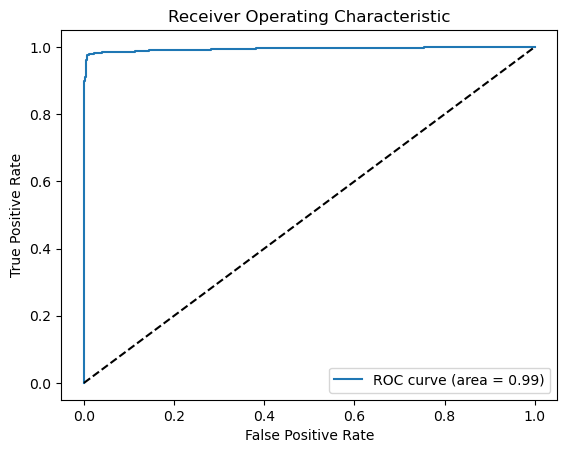

0.9943722357810543

In [18]:
x, y = zip(*test_dataset)
x = torch.stack(x)
y = torch.tensor(y)
y[y == 1] = 0
y[y == 9] = 1

model.eval()
_ = model(x)
y_score = model.score_samples(x)

from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr, tpr, _ = roc_curve(y, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
roc_auc


/tmp/ipykernel_8108/210049994.py:20: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


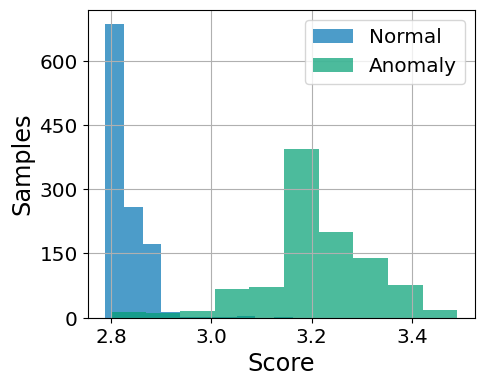

In [27]:
def generate_score_histogram(normal_score, anomaly_score, normal_bins=10, anomaly_bins=10):
    from matplotlib.ticker import MaxNLocator

    with plt.style.context('seaborn-colorblind'):
        fig = plt.figure(figsize=(5, 4))
        ax = plt.gca()
        ax.hist(normal_score, bins=normal_bins, alpha=.7, label='Normal')
        ax.hist(anomaly_score, bins=anomaly_bins, alpha=.7, label='Anomaly')
        ax.legend(fontsize='x-large')
        ax.xaxis.set_major_locator(MaxNLocator(nbins=5)) 
        ax.yaxis.set_major_locator(MaxNLocator(nbins=5))
        ax.set_ylabel('Samples', fontsize='xx-large')
        ax.set_xlabel('Score', fontsize='xx-large')
        ax.tick_params(axis='both', which='major', labelsize='x-large')
        ax.grid()
        
        return fig
    
fig = generate_score_histogram(y_score[y==0], y_score[y==1], 10, 10)
fig.show()
fig.savefig('adelen_novelties_score.pdf', bbox_inches='tight')

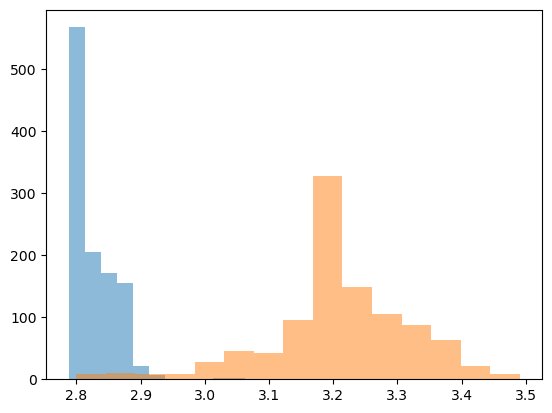

In [20]:
plt.hist(y_score[y==0], bins=15, alpha=0.5, label='Normal')
plt.hist(y_score[y==1], bins=15, alpha=0.5, label='Anomaly')
plt.show()

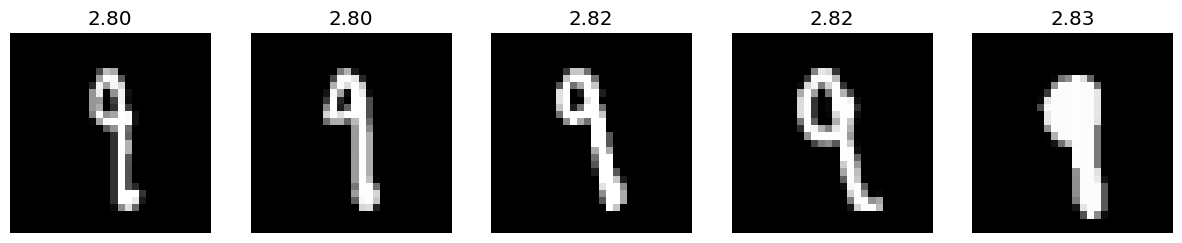

Anomalies with highest score


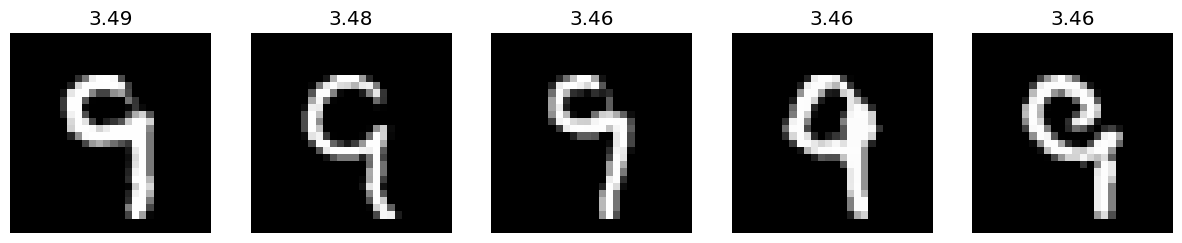

In [26]:
# show the anomalies with lowest score and the highest score
# lowest
anomalies = x[y == 1]
anomalies_score = y_score[y == 1]
idx = anomalies_score.argsort()

fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax[i].imshow(anomalies[idx[i]].squeeze(), cmap='gray')
    ax[i].axis('off')
    # indicate the score
    ax[i].set_title('%.2f' % anomalies_score[idx[i]], fontsize='x-large')
plt.savefig('non-detected_anomalies.pdf', bbox_inches='tight')
plt.show()


print('Anomalies with highest score')
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax[i].imshow(anomalies[idx[-(i+1)]].squeeze(), cmap='gray')
    ax[i].axis('off')
    # indicate the score
    ax[i].set_title('%.2f' % anomalies_score[idx[-(i+1)]], fontsize='x-large')
plt.savefig('detected_anomalies.pdf', bbox_inches='tight')
plt.show()





# Supervised DNN

In [ ]:
from experiments.utils.Supervised import SupervisedModel, train

supervised_model = SupervisedModel((28,28), [1, 32, 48], [1024, 256, 32, 2])
supervised_model = train(supervised_model, dataset, 128, 100, weighted_sampler=False)

In [ ]:
x, y = zip(*test_dataset)
x = torch.stack(x)
y = torch.tensor(y)
y[y == 1] = 0
y[y == 9] = 1

supervised_model.eval()
_ = supervised_model(x)
y_score = supervised_model.score_samples(x)

from sklearn.metrics import roc_curve, auc, roc_auc_score
fpr, tpr, _ = roc_curve(y, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
roc_auc

In [ ]:
plt.hist(y_score[y==0], bins=2, alpha=0.5, label='Normal')
plt.hist(y_score[y==1], bins=15, alpha=0.5, label='Anomaly')
plt.show()

In [ ]:
# show the anomalies with lowest score and the highest score
# lowest
anomalies = x[y == 1]
anomalies_score = y_score[y == 1]
idx = anomalies_score.argsort()

fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax[i].imshow(anomalies[idx[i]].squeeze(), cmap='gray')
    ax[i].axis('off')
    # indicate the score
    ax[i].set_title('%.2f' % anomalies_score[idx[i]])
plt.show()

print('Anomalies with highest score')
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax[i].imshow(anomalies[idx[-(i+1)]].squeeze(), cmap='gray')
    ax[i].axis('off')
    # indicate the score
    ax[i].set_title('%.2f' % anomalies_score[idx[-(i+1)]])
plt.show()